In [19]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_datasets as tfds

In [51]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


# ========== DESCARGA, LISTADO y AGRUPACION ==========

In [21]:
# Cargar dataset mnist_corrupted
dataset_identity = tfds.load('mnist_corrupted', as_supervised=True, with_info=True)[0]

# Cargar dataset mnist_corrupted/shot_noise
dataset_shotNoise = tfds.load('mnist_corrupted/shot_noise', as_supervised=True, with_info=True)[0]

# Cargar dataset mnist_corrupted/impulse_noise
dataset_inpulseNoise = tfds.load('mnist_corrupted/impulse_noise', as_supervised=True, with_info=True)[0]

# Cargar dataset mnist_corrupted/motion_blur
dataset_motionBlur = tfds.load('mnist_corrupted/motion_blur', as_supervised=True, with_info=True)[0]

# Cargar dataset mnist_corrupted/scale
dataset_scale = tfds.load('mnist_corrupted/scale', as_supervised=True, with_info=True)[0]

# Cargar dataset mnist_corrupted/translate
dataset_translate = tfds.load('mnist_corrupted/translate', as_supervised=True, with_info=True)[0]

In [22]:
train_dataset_identity, test_dataset_identity = dataset_identity['train'], dataset_identity['test']
train_dataset_shotNoise, test_dataset_shotNoise = dataset_shotNoise['train'], dataset_shotNoise['test']
train_dataset_impulseNoise, test_dataset_impulseNoise = dataset_inpulseNoise['train'], dataset_inpulseNoise['test']
train_dataset_motionBlur, test_dataset_motionBlur = dataset_motionBlur['train'], dataset_motionBlur['test']
train_dataset_scale, test_dataset_scale = dataset_scale['train'], dataset_scale['test']
train_dataset_translate, test_dataset_translate = dataset_translate['train'], dataset_translate['test']

In [23]:
train_data_identity = list(tfds.as_numpy(train_dataset_identity))
test_data_identity = list(tfds.as_numpy(test_dataset_identity))

train_data_shotNoise = list(tfds.as_numpy(train_dataset_shotNoise))
test_data_shotNoise = list(tfds.as_numpy(test_dataset_shotNoise))

train_data_impulseNoise = list(tfds.as_numpy(train_dataset_impulseNoise))
test_data_impulseNoise = list(tfds.as_numpy(test_dataset_impulseNoise))

train_data_motionBlur = list(tfds.as_numpy(train_dataset_motionBlur))
test_data_motionBlur = list(tfds.as_numpy(test_dataset_motionBlur))

train_data_scale = list(tfds.as_numpy(train_dataset_scale))
test_data_scale = list(tfds.as_numpy(test_dataset_scale))

train_data_translate = list(tfds.as_numpy(train_dataset_translate))
test_data_translate = list(tfds.as_numpy(test_dataset_translate))

In [24]:
def group(data):
  res = {}

  for index in range(len(data)):
    image = data[index][0]
    label = data[index][1]

    label = int(label)
    if label not in res:
      res[label] = []

    data[index] = (image, label, len(res[label]))

    res[label].append({
        "img": image,
        "label": label,
        "id": index
    })

  return res

group_train_dataset_identity = group(train_data_identity)
group_test_dataset_identity = group(test_data_identity)

group_train_dataset_shotNoise = group(train_data_shotNoise)
group_test_dataset_shotNoise = group(test_data_shotNoise)

group_train_dataset_impulseNoise = group(train_data_impulseNoise)
group_test_dataset_impulseNoise = group(test_data_impulseNoise)

group_train_dataset_motionBlur = group(train_data_motionBlur)
group_test_dataset_motionBlur = group(test_data_motionBlur)

group_train_dataset_scale = group(train_data_scale)
group_test_dataset_scale = group(test_data_scale)

group_train_dataset_translate = group(train_data_translate)
group_test_dataset_translate = group(test_data_translate)

# ========== MAKE ==========

In [25]:
import numpy as np
import random

```
fuzzy_logic = [
    "identicos"
    "casi identicos"
    "parecidos"
    "casi parecidos"
    "diferentes"
]
```

In [26]:
def make_pairs(data_identity, data_shotNoise, data_impulseNoise, data_motionBlur, data_scale, data_translate, group_identity, num_pairs):

    num_pairs = random.sample(range(0, num_pairs), num_pairs)

    pairs = []
    labels = []

    def append(img1, img2, value):
        pairs.append([img1, img2])
        labels.append(value)

    def other_img(label, idx):
      while True:
        data = random.choice(group_identity[label])

        if data["id"] != idx:
          return data["img"]

    def other_label(label):
      while True:
        label_dif = random.randint(0, 9)

        if label_dif != label:
          return random.choice(group_identity[label_dif])

    for idx in num_pairs:

        img_indentity, label_indentity, index_group = data_identity[idx]

        img_shotNoise = data_shotNoise[idx][0]

        img_impulseNoise = data_impulseNoise[idx][0]

        img_motionBlur = data_motionBlur[idx][0]

        img_scale = data_scale[idx][0]

        img_translate = data_translate[idx][0]

        # identicos
        append(img_indentity, img_indentity, "identicos")
        append(img_indentity, img_scale, "identicos")
        append(img_indentity, img_translate, "identicos")

        # casi identicos
        append(img_indentity, img_shotNoise, "casi identicos")
        append(img_scale, img_shotNoise, "casi identicos")

        # parecidos
        append(img_indentity, img_motionBlur, "parecidos")
        append(img_motionBlur, img_impulseNoise, "parecidos")

        # casi parecidos
        append(img_indentity, img_impulseNoise, "casi parecidos")
        img_other = other_img(label_indentity, idx)
        append(img_indentity, img_other, "casi parecidos")

        # diferente
        img_label = other_label(label_indentity)
        append(img_indentity, img_other, "diferente")

    return np.array(pairs), np.array(labels)

In [27]:
train_pairs, train_labels = make_pairs(
                              train_data_identity,
                              train_data_shotNoise,
                              train_data_impulseNoise,
                              train_data_motionBlur,
                              train_data_scale,
                              train_data_translate,
                              group_train_dataset_identity,
                              num_pairs=30000
                            )

test_pairs, test_labels = make_pairs(
                            test_data_identity,
                            test_data_shotNoise,
                            test_data_impulseNoise,
                            test_data_motionBlur,
                            test_data_scale,
                            test_data_translate,
                            group_test_dataset_identity,
                            num_pairs=5000
                          )

In [28]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Codificar las etiquetas
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Convertir a one-hot (para softmax)
num_classes = len(label_encoder.classes_)
train_labels_cat = to_categorical(train_labels_encoded, num_classes)
test_labels_cat = to_categorical(test_labels_encoded, num_classes)

In [29]:
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices(((train_pairs[:, 0], train_pairs[:, 1]), train_labels_cat))
train_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(((test_pairs[:, 0], test_pairs[:, 1]), test_labels_cat))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [30]:
def build_base_network(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Reshape((28, 28, 1))(inputs)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    return tf.keras.Model(inputs, x)

In [31]:
def build_siamese_network(input_shape, num_classes):
    base_network = build_base_network(input_shape)

    input_a = tf.keras.Input(shape=input_shape)
    input_b = tf.keras.Input(shape=input_shape)

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    l1_distance = tf.keras.layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))(
        [processed_a, processed_b]
    )
    x = tf.keras.layers.Dense(64, activation='relu')(l1_distance)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_a, input_b], outputs=outputs)
    return model

In [32]:
model = build_siamese_network(input_shape=(28, 28), num_classes=num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10
)

Epoch 1/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8686 - loss: 0.2766 - val_accuracy: 0.8990 - val_loss: 0.1430
Epoch 2/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.8944 - loss: 0.1494 - val_accuracy: 0.8996 - val_loss: 0.1409
Epoch 3/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.8966 - loss: 0.1445 - val_accuracy: 0.8990 - val_loss: 0.1447
Epoch 4/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.8963 - loss: 0.1445 - val_accuracy: 0.8997 - val_loss: 0.1403
Epoch 5/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.8974 - loss: 0.1442 - val_accuracy: 0.8994 - val_loss: 0.1421
Epoch 6/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.8972 - loss: 0.1424 - val_accuracy: 0.8995 - val_loss: 0.1420
Epoch 7/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.8962 - loss: 0.1435 - val_accuracy: 0.8993 - val_loss: 0.1419
Epoch 8/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.8961 - loss: 0

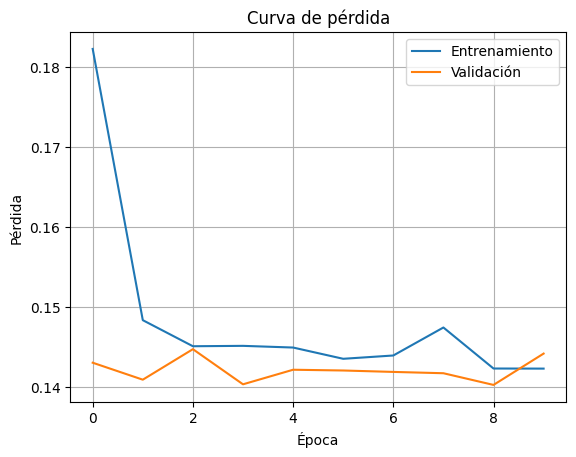

In [34]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curva de pérdida')
plt.legend()
plt.grid(True)
plt.show()

# **============ Predicciones ============**

In [35]:
train_pairs[:32].shape

(32, 2, 28, 28, 1)

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

# Split the test_pairs into two separate arrays for each image in the pair
test_pairs_a = test_pairs[:, 0]
test_pairs_b = test_pairs[:, 1]

predictions = model.predict([test_pairs_a, test_pairs_b])
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_labels_cat, axis=1)  # Use test_labels_cat for evaluation

print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

print("Matriz de confusión:")
print(confusion_matrix(y_true, y_pred))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

Reporte de clasificación:
                precision    recall  f1-score   support

casi identicos       1.00      1.00      1.00     10000
casi parecidos       0.67      0.99      0.80     10000
     diferente       0.49      0.01      0.02      5000
     identicos       1.00      1.00      1.00     15000
     parecidos       1.00      1.00      1.00     10000

      accuracy                           0.90     50000
     macro avg       0.83      0.80      0.76     50000
  weighted avg       0.88      0.90      0.86     50000

Matriz de confusión:
[[10000     0     0     0     0]
 [    0  9938    50    12     0]
 [    0  4938    50    12     0]
 [   15     0     2 14983     0]
 [    0     0     0     0 10000]]


# ========== SHOW ==========

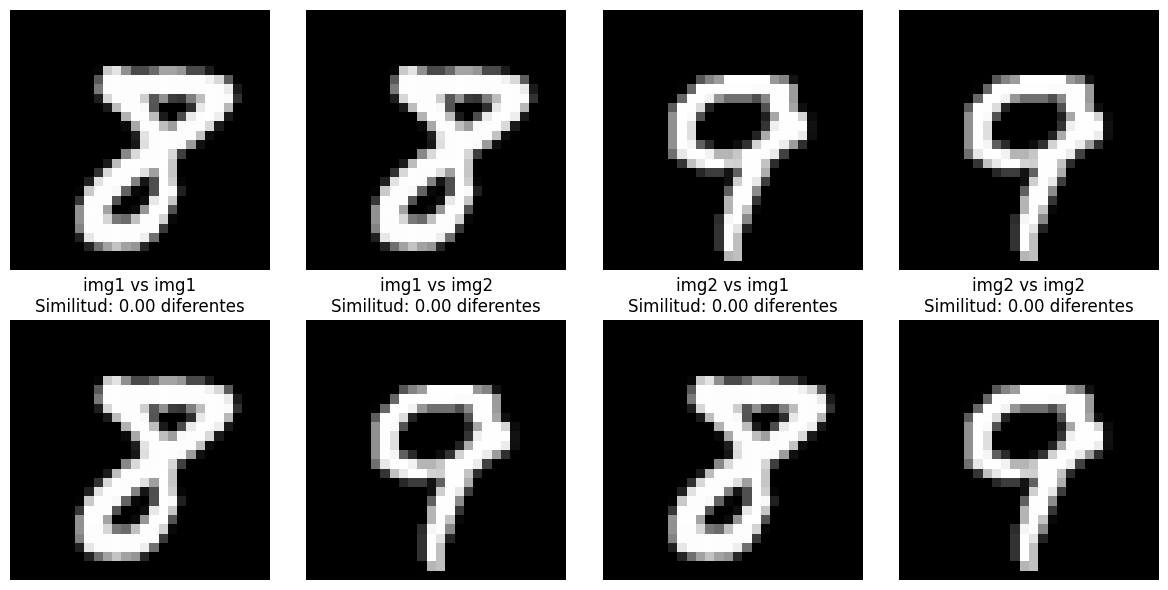

In [54]:
import matplotlib.pyplot as plt
# 1. Escoger dos imágenes aleatorias
td1, td2 = random.sample(test_data_identity, 2)

img1 = td1[0]
img2 = td2[0]

# 2. Preparar combinaciones
pairs = [
    (img1, img1, "img1 vs img1"),
    (img1, img2, "img1 vs img2"),
    (img2, img1, "img2 vs img1"),
    (img2, img2, "img2 vs img2"),
]

# 3. Realizar predicciones
predictions = []
for a, b, label in pairs:
    a_input = np.expand_dims(a, axis=0)  # (1, 28, 28)
    b_input = np.expand_dims(b, axis=0)
    pred = model.predict([a_input, b_input], verbose=0)[0][0]
    predictions.append((a, b, f"{pred:.2f} {fuzzy_label(pred)}", label))

# 4. Visualizar resultados
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, (img_a, img_b, pred, label) in enumerate(predictions):
    ax1 = axes[0, i]
    ax2 = axes[1, i]

    ax1.imshow(img_a, cmap='gray')
    ax1.axis('off')

    ax2.imshow(img_b, cmap='gray')
    ax2.axis('off')
    ax2.set_title(f"{label}\nSimilitud: {pred}")

plt.tight_layout()
plt.show()

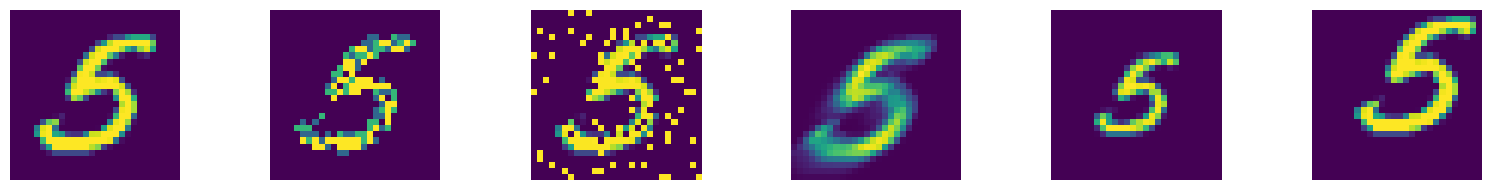

In [48]:
import matplotlib.pyplot as plt

# optional
def manual():
    label = 5

    id1 = group_train_dataset_identity[label]    [5]["id"]
    id2 = group_train_dataset_shotNoise[label]   [5]["id"]
    id3 = group_train_dataset_impulseNoise[label][5]["id"]
    id4 = group_train_dataset_motionBlur[label]  [5]["id"]
    id5 = group_train_dataset_scale[label]       [5]["id"]
    id6 = group_train_dataset_translate[label]   [5]["id"]

    img_1 = train_data_identity[id1][0]
    img_2 = train_data_shotNoise[id2][0]
    img_3 = train_data_impulseNoise[id3][0]
    img_4 = train_data_motionBlur[id4][0]
    img_5 = train_data_scale[id5][0]
    img_6 = train_data_translate[id6][0]

    fig, axes = plt.subplots(1, 6, figsize=(16, 2))

    axes[0].imshow(img_1)
    axes[0].axis("off")

    axes[1].imshow(img_2)
    axes[1].axis("off")

    axes[2].imshow(img_3)
    axes[2].axis("off")

    axes[3].imshow(img_4)
    axes[3].axis("off")

    axes[4].imshow(img_5)
    axes[4].axis("off")

    axes[5].imshow(img_6)
    axes[5].axis("off")

    plt.tight_layout()
    plt.show()


manual()